# What is F1 score?
**F1 Score**  
Binary混淆矩阵:  
$$predicted$$

|actual| P  | N  |
|------|---------|
|  P   | TP | FN |
|  N   | FP | TN |

**precision, recall, F1**
$$ precision = \frac{TP}{TP + FP}$$
$$ recall = \frac{TP}{TP + FN}$$
$$ F1=2*\frac{precision*recall}{precision + recall}$$

**求F1 score**  
给定y,y_pred:  
```python
import numpy as np
y = np.array([1,1,0,1,0,0,0,1])
y_pred = np.array([1,1,1,0,0,0,1,1])
from sklearn.metrics import f1_score
f1 = f1_score(y,y_pred)

TP = ((y==1) & (y_pred==1)).sum()
P_pred = y_pred.sum()
P_true = y.sum()
precision = float(TP)/P_pred
recall = float(TP)/P_true
f1 = 2*precision*recall / (precision + recall)
```

# Example
## Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit

# 为显示中文
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# all the features with target
df_train = pd.read_csv("total_feat_train.csv",index_col="个人编码")
# 所有特征
features = df_train.columns.difference(['target'])

In [3]:
model1_feat = pd.read_csv("model1_features.csv",index_col=0).index.unique()
model1_feat_apply = pd.read_csv("model1_feat_imp.csv",index_col=0,header=None).index
model2_feat = pd.read_csv("model2_features.csv",header=None).set_index(1).index.unique()
model2_feat_apply = pd.read_csv("model2_feat_imp.csv",index_col=0,header=None).index
predictors = model1_feat.union(model2_feat)

In [4]:
# 去除重复特征
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []
    for t, v in groups.items():
        dcols = frame[v].to_dict(orient="list")

        vs = dcols.values()
        ks = dcols.keys()
        lvs = len(vs)

        for i in range(lvs):
            for j in range(i+1,lvs):
                if vs[i] == vs[j]: 
                    dups.append(ks[i])
                    break

    return dups

dups = duplicate_columns(df_train[predictors])

In [5]:
predictors = predictors.difference(dups)
predictors = predictors.difference(["first_time"])
target = 'target'

In [6]:
df_train_test = df_train
print "Unbalance ratio: ", float(len(df_train_test[df_train_test[target] == 0])/len(df_train_test[df_train_test[target] == 1])),":",1
print "Unbalance:\n ", df_train_test[target].value_counts()

Unbalance ratio:  19.0 : 1
Unbalance:
  0    19000
1     1000
Name: target, dtype: int64


## Normalization

from sklearn.preprocessing import StandardScaler
StandardScaler().fit_transform(df_train_test['Age'].values[:,None])

In [7]:
from sklearn.preprocessing import StandardScaler
cols = predictors
Standard_cols = np.concatenate(map(lambda s: StandardScaler().fit_transform(s.values[:,None]), [df_train_test[col] for col in cols]),axis=1)
Standard_cols = pd.DataFrame(Standard_cols,columns = ["{}_{}".format("standard",col) for col in cols],index=df_train_test.index)

D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [8]:
df_train_test = pd.concat([df_train_test.drop(cols,axis=1),Standard_cols],axis=1)

**分层划分训练集和测试集**  
方法1： 
```python
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=0) #(返回的是样本，而非序号)  
```
方法2： 
```python
train, test = next(StratifiedShuffleSplit(n_splits=1,test_size=0.25).split(X,y)) #(返回的是序号，需要取样本)
train, test = StratifiedShuffleSplit(n_splits=1,test_size=0.25).split(X,y).next() #or

df_train = df_train_test.iloc[train,:]
df_test = df_train_test.iloc[test,:]
```

In [9]:
predictors = df_train_test.columns.difference(['target'])
ss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
train, test = ss.split(df_train_test[predictors],df_train_test[target]).next()
print 'train: ',len(train)
print 'test: ',len(test)
print 'ratio',float(len(test))/(len(train)+len(test))

train:  16000
test:  4000
ratio 0.2


In [10]:
df_train = df_train_test.iloc[train,:]
df_test = df_train_test.iloc[test,:]

In [11]:
pd.set_option('display.max_columns',100)
df_train[predictors].head() 

,disease_\,disease_Ⅱ型糖尿病,disease_Ⅱ型糖尿病合并肾病,disease_Ⅱ型糖尿病性周围神经病变,disease_Ⅱ型糖尿病性周围血管病,disease_Ⅱ型糖尿病糖尿病合并肾损伤,disease_一线他汀不耐受,disease_一线治疗不达标,disease_一线治疗无效二线治疗,disease_一线用药不达标,disease_一线药物不耐受,disease_一线药物效果不佳,disease_一线药物治疗无效行二线治疗,disease_一线降脂药不耐受,disease_一线降脂药效果不佳,disease_一线降脂药无效,disease_一线降脂药物不耐受偏瘫,disease_一线降脂药物不耐受偏瘫门特,disease_一线降脂药物不耐受脑供血不足偏瘫,disease_一线降脂药物不耐受脑梗塞,disease_一线降脂药物治疗效果欠佳,disease_上呼吸道感染,disease_下消,disease_下焦湿热证,disease_下焦湿盛,disease_下肢,disease_下肢动脉栓塞,disease_下肢动脉硬化,disease_下肢动脉硬化闭塞症,disease_下肢动脉粥样硬化,disease_下肢动脉粥样硬化闭塞症,disease_下肢动脉闭塞,disease_下肢动脉闭塞症,disease_下肢循环障碍,disease_下肢微循环障碍,disease_下肢血管闭塞症,disease_下肢静脉回流障碍,disease_下肢静脉炎,disease_不伴有并发症的,disease_不寐病,disease_不稳定型心绞痛,disease_不稳定性心绞痛,disease_不稳定性心绞痛脑梗塞偏瘫,disease_不稳定性心绞痛高血压,disease_不稳定糖尿病,disease_不耐受冠心病,disease_不能口服,disease_不能手术的晚期胃癌,disease_不能耐受,disease_不适用胰岛药物且使用其他口服降糖药物无效,...,standard_药品费自费金额_sum,standard_补助审批金额_max,standard_补助审批金额_mean,standard_补助审批金额_q1,standard_补助审批金额_q2,standard_补助审批金额_q3,standard_补助审批金额_std,standard_补助审批金额_sum,standard_贵重检查费金额_max,standard_贵重检查费金额_mean,standard_贵重检查费金额_q1,standard_贵重检查费金额_q2,standard_贵重检查费金额_q3,standard_贵重检查费金额_std,standard_贵重检查费金额_sum,standard_贵重药品发生金额_max,standard_贵重药品发生金额_mean,standard_贵重药品发生金额_q1,standard_贵重药品发生金额_q2,standard_贵重药品发生金额_q3,standard_贵重药品发生金额_std,standard_贵重药品发生金额_sum,standard_起付标准以上自负比例金额_max,standard_起付标准以上自负比例金额_mean,standard_起付标准以上自负比例金额_q1,standard_起付标准以上自负比例金额_q2,standard_起付标准以上自负比例金额_q3,standard_起付标准以上自负比例金额_std,standard_起付标准以上自负比例金额_sum,standard_起付线标准金额_max,standard_起付线标准金额_mean,standard_起付线标准金额_std,standard_起付线标准金额_sum,standard_非账户支付金额_max,standard_非账户支付金额_mean,standard_非账户支付金额_q1,standard_非账户支付金额_q2,standard_非账户支付金额_q3,standard_非账户支付金额_std,standard_非账户支付金额_sum,standard_高价材料发生金额_max,standard_高价材料发生金额_mean,standard_高价材料发生金额_q3,standard_高价材料发生金额_std,standard_高价材料发生金额_sum,床位费申报金额_q1,床位费申报金额_q2,手术费发生金额_q1,手术费发生金额_q2,手术费发生金额_q3
个人编码,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
352121000685621,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.050711,-0.228059,-0.264293,-0.165607,-0.233539,-0.240654,-0.244268,-0.235231,-0.218909,-0.125692,-0.015165,-0.034875,-0.069944,-0.188932,-0.142793,-0.448716,-0.275203,-0.054134,-0.102056,-0.193077,-0.419653,-0.372051,-0.240314,-0.143943,-0.367730,0.025548,-0.102781,-0.196771,0.129713,-0.066357,-0.053543,-0.061325,-0.05739,-0.369879,-0.636206,-0.358893,-0.577473,-0.577891,-0.441796,-0.539958,-0.027386,-0.037757,-0.01583,-0.032644,-0.034542,0.0,0.0,0.0,0.0,0.0
352120001925954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.089992,-0.228059,-0.264293,-0.165607,-0.233539,-0.240654,-0.244268,-0.235231,-0.218909,-0.125692,-0.015165,-0.034875,-0.069944,-0.188932,-0.142793,0.803799,0.395715,-0.054134,-0.102056,-0.193077,1.047709,0.095814,-0.244182,-0.180778,-0.379970,0.093541,-0.283019,-0.221364,-0.569976,-0.066357,-0.053543,-0.061325,-0.05739,-0.084748,-0.101540,-0.348054,0.076087,-0.202200,-0.001106,-0.479520,-0.027386,-0.037757,-0.01583,-0.032644,-0.034542,0.0,0.0,0.0,0.0,0.0
352120002111431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.256222,-0.228059,-0.264293,-0.165607,-0.233539,-0.240654,-0.244268,-0.235231,-0.218909,-0.125692,-0.015165,-0.034875,-0.069944,-0.188932,-0.142793,-0.133131,-0.209784,-0.054134,-0.102056,-0.193077,-0.179027,-0.272075,-0.254817,-0.022588,0.198372,0.377997,-0.044947,-0.188438,-0.212590,-0.066357,-0.053543,-0.061325,-0.05739,-0.128310,0.098993,-0.062521,0.491761,0.014332,-0.092656,-0.088525,-0.027386,-0.037757,-0.01583,-0.032644,-0.034542,0.0,0.0,0.0,0.0,0.0
352120003502330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.089992,-0.228059,-0.264293,-0.165607,-0.233539,-0.240654,-0.244268,-0.235231,-0.218909,-0.125692,-0.015165,-0.034875,-0.069944,-0.188932,

## Logistic model

help

```python
fold = KFold(5,shuffle=False)
i = 0
for iteration, indices in enumerate(fold.split(df_train[target])):
    print iteration, indices
    if i > 2:
        break
```

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

def print_Kfold_scores(x_train_data, y_train_data):
    fold = KFold(5,shuffle=False)
    
    # C parameters
    #c_param_range = [0.05,0.1,0.2]
    c_param_range = [0.001]
    
    result_table = pd.DataFrame(index=range(len(c_param_range)), columns=['C_parameters','Mean f1 score'])
    result_table['C_parameters'] = c_param_range
    
    j = 0
    for c_param in c_param_range:
        print '--------------------------------------------'
        print 'C parameter: ', c_param
        print '--------------------------------------------'
        print ''
        
        recall_accs = []
        for iteration, indices in enumerate(fold.split(y_train_data)):
            # call logistic model with a certain c_param
            #lr = LogisticRegression(C=c_param, penalty='l1',class_weight='balanced')
            #lr = LogisticRegression(C=c_param, penalty='l1',class_weight='balanced')
            lr = LogisticRegression(C=c_param, penalty='l2')
            # train
            lr.fit(x_train_data.iloc[indices[0],:], y_train_data.iloc[indices[0]].values.ravel())
            # test
            y_pred = lr.predict(x_train_data.iloc[indices[1],:].values)
            y_pred_proba = lr.predict_proba(x_train_data.iloc[indices[1],:].values)[:,1]
            #y_pred = np.zeros_like(y_pred_proba)
            #y_pred[y_pred_proba>0.03] = 1  # 大于0.05预测为正例
            # calculate the recall score
            #recall_accs.append(recall_score(y_train_data.iloc[indices[1]].values, y_pred))
            # calculate the f1 score
            #recall_accs.append(f1_score(y_train_data.iloc[indices[1],:].values, y_pred_undersample))
            # caculate the auc score
            recall_accs.append(roc_auc_score(y_train_data.iloc[indices[1]].values, y_pred_proba))

        # mean value of those recall score is the metric we want to save and get hold of.
        result_table.ix[j,'Mean auc score'] = np.mean(np.array(recall_accs))
        j += 1
        print ""
        print 'Mean auc score ', np.mean(np.array(recall_accs))
        print ""
    best_c = result_table.loc[result_table['Mean auc score'].idxmax()]['C_parameters']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print '*********************************************************************************'
    print 'Best model to choose from cross validation is with C parameter = ', best_c
    print '*********************************************************************************'
    
    return best_c

In [ ]:
best_c = print_Kfold_scores(df_train[predictors], df_train[target])   #0.8688 0.05

## Create a function to plot a fancy confusion matrix

In [11]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.ion()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Predictions on test set and plotting confusion matrix

F1 score:  0.425249169435
Recall metric in testing dataset:  0.32


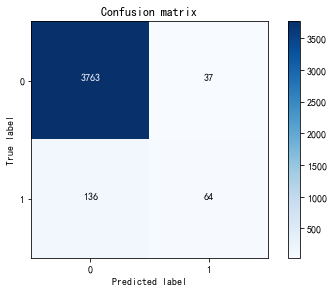

In [12]:
best_c = 0.01    #l1 正则化时 best_c = 0.2 左右 
#lr = LogisticRegression(C = best_c, penalty='l2',class_weight='balanced')

lr = LogisticRegression(C = best_c, penalty='l2')
lr.fit(df_train[predictors], df_train[target].values.ravel())
y_pred = lr.predict(df_test[predictors].values)
y_pred_proba = lr.predict_proba(df_test[predictors].values)[:,1]

#y_pred = np.zeros_like(y_pred_proba)
#y_pred[y_pred_proba>0.03] = 1  # 大于0.03预测为正例

print "F1 score: ", f1_score(df_test[target], y_pred)

# confusion matrix
cnf_matrix = confusion_matrix(df_test[target], y_pred)
np.set_printoptions(precision=2)

print "Recall metric in testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1])

# plot non_normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title='Confusion matrix')
plt.show()

## The whole data set

F1 score:  0.525737817433
Recall metric in testing dataset:  0.383


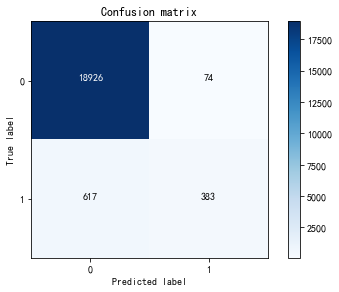

In [13]:
y_pred = lr.predict(df_train_test[predictors].values)
y_pred_proba = lr.predict_proba(df_train_test[predictors].values)[:,1]

#y_pred = np.zeros_like(y_pred_proba)
#y_pred[y_pred_proba>0.03] = 1  # 大于0.03预测为正例

print "F1 score: ", f1_score(df_train_test[target], y_pred)

# confusion matrix
cnf_matrix = confusion_matrix(df_train_test[target], y_pred)
np.set_printoptions(precision=2)

print "Recall metric in testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1])

# plot non_normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title='Confusion matrix')
plt.show()

## ROC curve

D:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


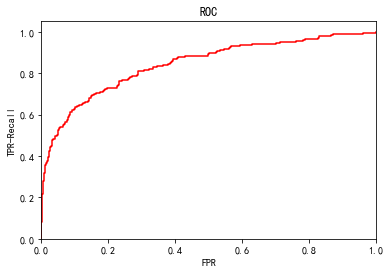

In [14]:
from sklearn.metrics import roc_curve, auc
#lr = LogisticRegression(C = best_c, penalty='l1')
#lr.fit(df_train[predictors], df_train[target].values.ravel())
y_pred = lr.predict(df_test[predictors].values)
y_pred_proba = lr.predict_proba(df_test[predictors].values)[:,1]
fpr, tpr, thresholds = roc_curve(df_test[target].values,y_pred_proba)
# Plot Precision-Recall curve
plt.plot(fpr, tpr, color='r')
plt.xlabel('FPR')
plt.ylabel('TPR-Recall')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC')
plt.legend()

## Precision-Recall curve

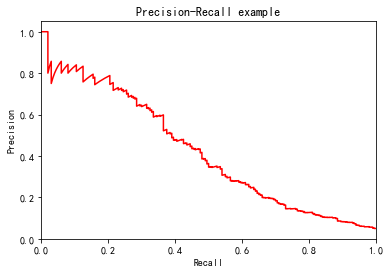

In [15]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(df_test[target].values,y_pred_proba)
# Plot Precision-Recall curve
plt.plot(recall, precision, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example')
plt.legend()

In [58]:
2*(0.6*0.4)/(0.6+0.4)
np.arange(1,10)/20.0

array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45])

# Changing Threshold
## Precision-Recall curve

Threshold:  0.1 , F1 score: [ 0.1   0.39  0.  ]
[ 0.05  0.29  1.  ] [ 1.    0.61  0.  ] [False  True]
Threshold:  0.2 , F1 score: [ 0.1   0.46  0.  ]
[ 0.05  0.46  1.  ] [ 1.    0.47  0.  ] [False  True]
Threshold:  0.3 , F1 score: [ 0.1   0.47  0.  ]
[ 0.05  0.59  1.  ] [ 1.    0.39  0.  ] [False  True]
Threshold:  0.4 , F1 score: [ 0.1   0.43  0.  ]
[ 0.05  0.68  1.  ] [ 1.    0.32  0.  ] [False  True]
Threshold:  0.5 , F1 score: [ 0.1   0.42  0.  ]
[ 0.05  0.72  1.  ] [ 1.    0.29  0.  ] [False  True]
Threshold:  0.6 , F1 score: [ 0.1   0.38  0.  ]
[ 0.05  0.77  1.  ] [ 1.    0.26  0.  ] [False  True]
Threshold:  0.7 , F1 score: [ 0.1   0.33  0.  ]
[ 0.05  0.79  1.  ] [ 1.   0.2  0. ] [False  True]
Threshold:  0.8 , F1 score: [ 0.1  0.3  0. ]
[ 0.05  0.84  1.  ] [ 1.    0.18  0.  ] [False  True]
Threshold:  0.9 , F1 score: [ 0.1   0.19  0.  ]
[ 0.05  0.79  1.  ] [ 1.    0.11  0.  ] [False  True]


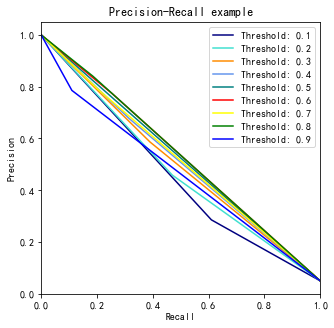

In [23]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve

#lr = LogisticRegression(C = best_c, penalty='l1')
#lr.fit(df_train[predictors], df_train[target].values.ravel())
y_pred_proba = lr.predict_proba(df_test[predictors].values)

thresholds = np.arange(1,10)/10.0
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_proba[:,1] > i
    
    #print "Threshold: ",i,", F1 score:", f1_score(df_test[target],y_test_predictions_prob)
    
    precision, recall, thresholds = precision_recall_curve(df_test[target],y_test_predictions_prob)
    print "Threshold: ",i,", F1 score:", 2*precision*recall/(precision+recall)
    print precision, recall, thresholds
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend()

## confusion matrix

Threhold >= 0.1,  F1 score:  0.391025641026
Threhold >= 0.2,  F1 score:  0.454106280193
Threhold >= 0.3,  F1 score:  0.46511627907
Threhold >= 0.4,  F1 score:  0.452229299363
Threhold >= 0.5,  F1 score:  0.439862542955
Threhold >= 0.6,  F1 score:  0.401433691756
Threhold >= 0.7,  F1 score:  0.365019011407
Threhold >= 0.8,  F1 score:  0.314516129032
Threhold >= 0.9,  F1 score:  0.257510729614


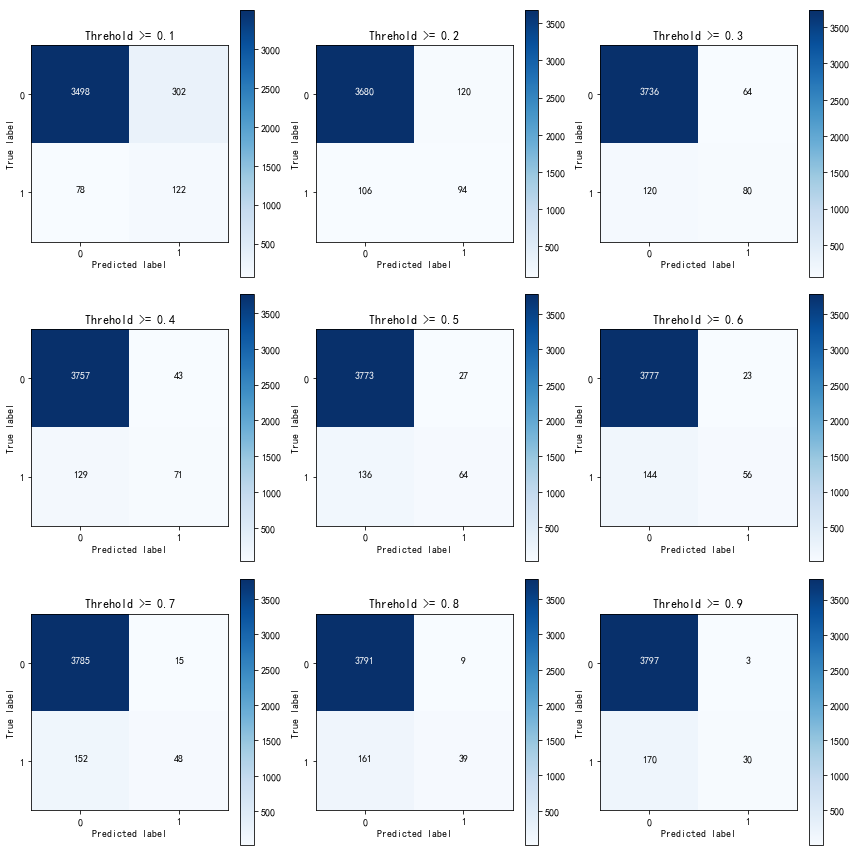

In [19]:
#lr = LogisticRegression(C = best_c, penalty='l1')
#lr.fit(df_train[predictors], df_train[target].values.ravel())
y_pred_proba = lr.predict_proba(df_test[predictors].values)

thresholds = np.arange(1,10)/10.0
plt.figure(figsize=(12,12))
j  = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] > i
    plt.subplot(3,3,j)
    j += 1
    
    # compute confusion matrix
    cnf_matrix = confusion_matrix(df_test[target], y_test_predictions_high_recall)
    #print "Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[0,1]+cnf_matrix[1,1])
    print 'Threhold >= %s, '%i,"F1 score: ", f1_score(df_test[target], y_test_predictions_high_recall)
    
    # plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix,classes=class_names,title='Threhold >= %s'%i)

# ROC <=> PR ?
## when steepness of the curve

[**Momentum (technical analysis)**](https://en.wikipedia.org/wiki/Momentum_(technical_analysis))  
https://www.medcalc.org/manual/nonlinearregression_example.php

In [16]:
coef = pd.Series(data = lr.coef_.ravel(),index=predictors)

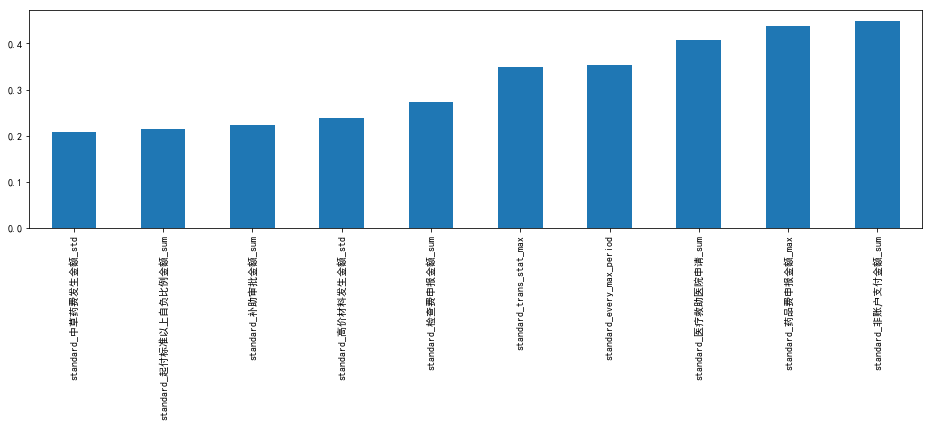

In [17]:
fig = plt.subplots(figsize=(16,4))
coef.sort_values()[-10:].plot(kind='bar')

In [18]:
coef[coef==0]

standard_day_to_nhospitals      0.0
standard_every_ave_period       0.0
standard_every_period_1         0.0
standard_every_period_14        0.0
standard_every_q1_period        0.0
standard_every_q2_period        0.0
standard_fee_buzhu_mean         0.0
standard_fee_buzhu_sum          0.0
standard_fee_fasheng_mean       0.0
standard_fee_fasheng_sum        0.0
standard_fee_shenbao_mean       0.0
standard_fee_shenbao_sum        0.0
standard_fee_zhifu_mean         0.0
standard_fee_zhifu_sum          0.0
standard_fee_zifei_mean         0.0
standard_fee_zifei_sum          0.0
standard_first_time             0.0
standard_num_total_hospitals    0.0
standard_total_rate             0.0
standard_一次性医用材料申报金额_q1         0.0
standard_一次性医用材料申报金额_q2         0.0
standard_一次性医用材料申报金额_std        0.0
standard_一次性医用材料申报金额_sum        0.0
standard_三目统计项目_q1              0.0
standard_三目统计项目_std             0.0
standard_三目统计项目_sum             0.0
standard_中成药费发生金额_mean          0.0
standard_中成药费发生金额_q1        

# Conclusion

**对于Logistic模型来说：**  
- 'l1'正则化比'l2'正则化要好
- 精简后的特征数据，性能不比之前差
- 'balanced'对结果似乎有影响
- log变换？ not good!

需要进一步分析调优！